# Survival Analysis


#### TODO

- Implement different metric
- Implement simulation in a different script

In [1]:
random_state = 20
min_operating_time = 30
figsize = (8,6)
features = 'tsfresh_features_sel' # 'hos_features' # tsfresh_features_sel

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])

from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.ensemble import RandomSurvivalForest

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

### Data retrieval

In [3]:
df_l = []

for generator in range(1,5):

    df = pd.read_csv(f'../data/prepared/ap{generator}_data.csv')

    df['time'] = df.groupby('Run').cumcount(ascending=True)
    df['generator'] = generator

    df.rename(columns={'Vazão Turbinado':'Vazão Turbinada'}, inplace=True)

    df = df.drop(columns=['Gerador - Energia Consumida', 'Gerador - Energia Ativa Fornecida',
       'Gerador - Energia Reativa Fornecida',  'Gerador - Horímetro Elétrico', 'Gerador - Horímetro Mecânico'])


    df_l.append(df)

df = pd.concat(df_l)

df['id'] = df['generator'].astype(str) + '-' + df['Run'].astype(str)

df.head()

,E3TimeStamp,Gerador - Corrente Média,Gerador - Corrente R,Gerador - Corrente S,Gerador - Corrente T,Gerador - Frequência,Gerador - Potência Ativa Média,Gerador - Potência Reativa Média,Gerador - Tensão RN,Gerador - Tensão SN,...,Vazão Turbinada,RegV - Rotor,Gerador - Potência Aparente Média,EVI,isMissing,Breakdown,Run,time,generator,id
0,2018-07-01 00:00:00,228.0,227.0,230.0,227.0,60.000000,5660.0,126.0,8.27,8.25,...,0.0,90.300003,5662.0,0.690869,0.0,False,0,0,1,1-0
1,2018-07-01 00:05:00,233.0,233.0,235.0,232.0,59.990002,5708.0,123.0,8.26,8.24,...,0.0,91.599998,5709.0,0.873441,0.0,False,0,1,1,1-0
2,2018-07-01 00:10:00,235.0,234.0,237.0,234.0,60.000000,5838.0,112.0,8.27,8.25,...,0.0,91.300003,5839.0,0.705691,0.0,False,0,2,1,1-0
3,2018-07-01 00:15:00,232.0,227.0,230.0,231.0,60.000000,5636.0,132.0,8.26,8.24,...,0.0,89.199997,5638.0,0.691231,0.0,False,0,3,1,1-0
4,2018-07-01 00:20:00,235.0,233.0,237.0,234.0,60.009998,5794.0,130.0,8.27,8.25,...,0.0,91.199997,5795.0,0.817129,0.0,False,0,4,1,1-0


#### Group data per generator-run

In [4]:
# Get data fror
data = df.dropna().groupby('id').agg({
    'Run':'median',
    'Breakdown':'median',
    'time':'max',
})

data = data[data['time'] > min_operating_time] # Select only runs with time 

data['Breakdown'] = data['Breakdown'].astype(bool)

data.head()

,Run,Breakdown,time
id,,,
1-0,0,False,669
1-1,1,False,1409
1-10,10,False,170
1-100,100,False,90
1-101,101,False,31


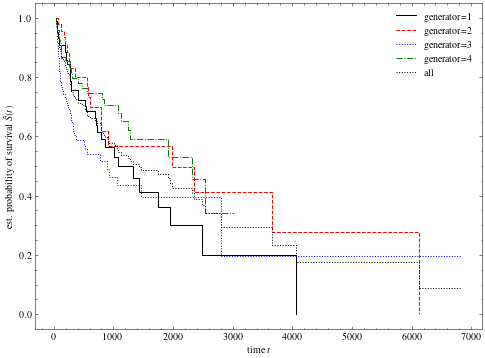

In [5]:
data['generator'] = data.reset_index()['id'].str.split('-', expand=True)[0].astype(int).values

plt.figure(figsize=figsize)

for generator in range(1,5):

    mask = data["generator"] == generator

    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data.loc[data.generator == generator, "Breakdown"], 
        data.loc[data.generator == generator, "time"])

    plt.step(time_treatment, survival_prob_treatment, where="post",
                label=f"generator={generator}")

time_treatment, survival_prob_treatment = kaplan_meier_estimator(
    data['Breakdown'], data['time'])

plt.step(time_treatment, survival_prob_treatment, where="post",
            label="all", c='k', ls=":")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

#### Load features

In [6]:
if features == 'hos_features':
    df_feature = pd.read_csv('../data/preprocessed/hos_features.zip', compression='zip', index_col=0, skiprows=[1,2])
else:
    df_feature = pd.read_csv('../data/preprocessed/tsfresh_features_sel.zip', index_col=0, compression='zip')
    df_feature = df_feature.loc[:, ~df_feature.columns.str.contains('length|sum|count')]

df_feature = df_feature.reindex(data.index)
df_feature.head()

,Conduto - Pressão__autocorrelation__lag_1,"Turbina - Temperatura MC Sapatas Axiais Contra Escora 01__fft_coefficient__attr_""abs""__coeff_1","Gerador - Temperatura Mancal LA Casquilho 02__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)","Gerador - Temperatura Mancal LA Casquilho 01__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)","Turbina - Temperatura MC Sapatas Axiais Contra Escora 02__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)","Gerador - Temperatura Mancal LNA Casquilho 01__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)","Turbina - Temperatura MC Bucha Radial__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)","Gerador - Temperatura Mancal LNA Casquilho 02__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)",Gerador - Temperatura Mancal LNA Casquilho 01__variance_larger_than_standard_deviation,"Conduto - Pressão__agg_autocorrelation__f_agg_""mean""__maxlag_40",...,"Gerador - Temperatura Mancal LA Casquilho 01__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)",RegV - Rotor__autocorrelation__lag_6,"UHCT Pressão Óleo__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","Vibração Mancal Combinado Lado Acoplado__linear_trend__attr_""stderr""","Vazão Turbinada__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","Gerador - Corrente T__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0",UHLM - Tenperatura Óleo__energy_ratio_by_chunks__num_segments_10__segment_focus_8,"Turbina - Temperatura MC Sapatas Axiais Contra Escora 02__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""",UHLM - Tenperatura Óleo__partial_autocorrelation__lag_6,"Turbina - Temperatura Gaxeteiro Jusante__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC"""
id,,,,,,,,,,,,,,,,,,,,,
1-0,0.919630,846.425434,30.093585,27.864464,23.207909,27.307175,19.505125,27.307175,1.0,0.648138,...,83.785267,0.736144,0.282449,3.552731e-06,0.000000,15.998054,0.103076,40.261692,-0.015347,10.0
1-1,0.798812,4509.274592,11.508219,8.566762,7.276333,10.393492,7.881435,12.631112,1.0,0.306932,...,42.937212,0.453770,0.317708,9.886715e-07,0.000000,427.369222,0.103153,40.641932,0.018331,14.0
1-10,0.806278,369.461473,26.250341,25.792058,19.487104,24.350405,15.957657,24.380233,1.0,0.060774,...,70.783722,0.360859,0.218858,0.000000e+00,0.000000,0.000000,0.074081,27.828571,0.112585,2.0
1-100,0.738528,272.702857,16.561928,14.103825,9.874475,15.446134,12.306315,16.560694,1.0,0.096653,...,52.481655,0.564615,2.187500,1.326219e-04,3.224888,1.583333,0.102440,32.542105,0.076602,3.0
1-101,0.092742,113.854025,12.102471,10.756764,9.285939,11.632461,10.758820,12.949723,1.0,-0.008502,...,99.675820,0.619772,0.000000,5.666729e-04,0.052560,40.500000,0.108415,26.607143,0.015887,1.0


In [7]:
y = np.zeros(len(data), dtype={'names': ('cens', 'time'), 'formats': ('?', '<f8')})
y['cens'] = data['Breakdown'].tolist()
y['time'] = data['time'].tolist()

X = df_feature.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=random_state)

In [8]:
models = [

    ('CoxNet', CoxnetSurvivalAnalysis()),

    ('RSF', RandomSurvivalForest(n_estimators=100,
                            min_samples_split=10,
                            min_samples_leaf=15,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=random_state)),

    ('GBSA', GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, random_state=random_state)),
]

for model_name, model in models:

    model.fit(X_train, y_train)

    print(model_name)
    print(model.score(X_test, y_test).round(3))

/var/folders/9f/4pvv3tjj2fn5rn8tg9h7rv8h0000gn/T/ipykernel_17268/742871589.py:17: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  model.fit(X_train, y_train)


CoxNet
0.916
RSF
0.983
GBSA
0.956


### Model convergence analysis

In [9]:
results = {}

for min_samples in [5,10,25,50]:
    scores = []
    
    rsf = RandomSurvivalForest(n_estimators=1,
                        #min_samples_split=10,
                        min_samples_leaf=min_samples,
                        max_features="sqrt",
                        n_jobs=-1,
                        warm_start=True,
                        random_state=random_state)
        
    for n in range(1,500):
        rsf.n_estimators += 1
        rsf.fit(X_train, y_train)
        scores.append(rsf.score(X_test, y_test))
    results.update({min_samples:scores})
    

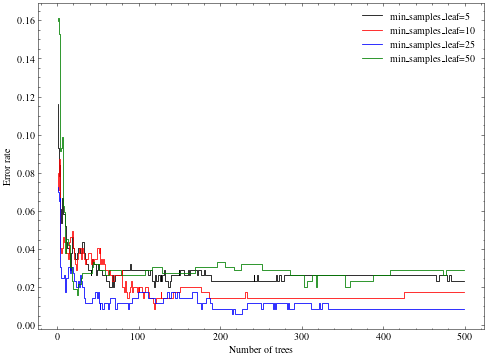

In [10]:
plt.figure(figsize=figsize)
    
for key, value in results.items():

    plt.step(range(1,500), 1-np.array(value), label="min_samples_leaf={}".format(key), ls='-', lw=0.8)
    plt.xlabel('Number of trees')
    plt.ylabel('Error rate')
    plt.legend()

### Survival and Hazard function

In [11]:
rsf = RandomSurvivalForest(n_estimators=100,
                            min_samples_split=10,
                            min_samples_leaf=15,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=random_state)

rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_jobs=-1, random_state=20)

Text(0.5, 0, 'Time in days')

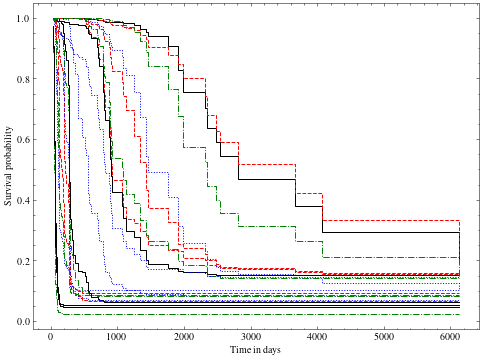

In [12]:
surv = rsf.predict_survival_function(X_test[:20], return_array=True)

plt.figure(figsize=figsize)
for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")

Text(0.5, 0, 'Time in days')

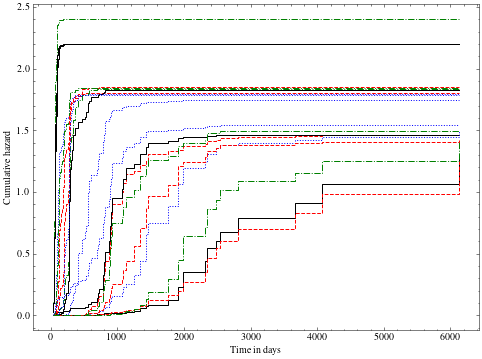

In [13]:
surv = rsf.predict_cumulative_hazard_function(X_test[:20], return_array=True)

plt.figure(figsize=figsize)
for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")

### Feature importance

In [14]:
import eli5
from eli5.sklearn import PermutationImportance

feature_names = df_feature.columns.tolist()
perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.0130 ± 0.0141,"Vibração Mancal Combinado Radial Vertical__fft_aggregated__aggtype_""variance"""
0.0114 ± 0.0109,Gerador - Temperatura de Enrolamento fase T__lempel_ziv_complexity__bins_5
0.0076 ± 0.0106,Gerador - Temperatura de Enrolamento fase S__lempel_ziv_complexity__bins_3
0.0070 ± 0.0134,"Barra - Tensão__fft_coefficient__attr_""abs""__coeff_0"
0.0070 ± 0.0110,"UHCT Pressão Óleo__fft_coefficient__attr_""real""__coeff_0"
0.0068 ± 0.0073,"Gerador - Temperatura de Enrolamento fase T__fft_aggregated__aggtype_""variance"""
0.0064 ± 0.0088,"Barra - Tensão__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)"
0.0058 ± 0.0088,"Turbina - Temperatura MC Bucha Radial__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)"
0.0058 ± 0.0118,"Gerador - Corrente S__fft_aggregated__aggtype_""variance"""
0.0058 ± 0.0116,UHCT Pressão Óleo__percentage_of_reoccurring_datapoints_to_all_datapoints
